In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0


In [2]:
import tensorflow as tf; print(tf.config.list_physical_devices("GPU"))

2024-02-21 23:12:31.183651: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 23:12:31.183730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 23:12:31.185083: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 23:12:31.192166: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 23:12:32.317732: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-21 23:12:33.593495: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 23:12:33.614631: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 23:12:33.614904: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
import pandas as pd

DATAPATH = "data"

df = pd.read_csv(f"{DATAPATH}/fried_noodles_dataset.csv")
df["c"] = 0b000  # meat, veggie, noodle
df

,filename,meat,veggie,noodle,c
0,0-food_tray-10-top.jpg,0,0,0,0
1,0-food_tray-12-top.jpg,0,0,0,0
2,0-food_tray-13-top.jpg,0,0,0,0
3,0-food_tray-14-top.jpg,0,0,0,0
4,0-food_tray-16-top.jpg,0,0,0,0
...,...,...,...,...,...
1851,2020_09_18-266-top.jpg,15,15,60,0
1852,2020_09_18-267-top.jpg,15,15,60,0
1853,2020_09_18-268-top.jpg,15,15,60,0
1854,2020_09_18-269-top.jpg,15,15,60,0


In [4]:
df.loc[df["meat"] > 0, "c"] = df.loc[df["meat"] > 0, "c"] | 0b100
df.loc[df["veggie"] > 0, "c"] = df.loc[df["veggie"] > 0, "c"] | 0b010
df.loc[df["noodle"] > 0, "c"] = df.loc[df["noodle"] > 0, "c"] | 0b001
df["c"].value_counts()

c
7    891
2    254
3    247
1    158
4    129
6     96
5     57
0     24
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

train_set, validation_set = train_test_split(df, train_size=0.8, stratify=df[['c']])

train_set['c'].value_counts(normalize=True).compare(validation_set['c'].value_counts(normalize=True))

,self,other
c,,
7,0.479784,0.481183
2,0.136792,0.137097
3,0.133423,0.131720
1,0.084906,0.086022
4,0.069407,0.069892
6,0.051887,0.051075
5,0.030997,0.029570
0,0.012803,0.013441


In [6]:
# copying the data
target = 100
l = train_set['c'].value_counts().copy()
for i, r in l.items():
    if r < target:
        c = r
        while (c < target):
            sampled_n = min(len(train_set[train_set["c"] == i]), (target-c))
            sampled = train_set[train_set["c"] == i].sample(n=sampled_n)
            train_set = pd.concat([train_set, sampled], ignore_index=True)
            c += sampled_n

train_set["c"].value_counts(), len(train_set)

(c
 7    712
 2    203
 3    198
 1    126
 4    103
 5    100
 6    100
 0    100
 Name: count, dtype: int64,
 1642)

In [7]:
from keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    img_to_array,
    load_img,
)

img_size = (300, 500)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    train_set,
    directory=f"{DATAPATH}/images/",
    x_col="filename",
    y_col=["meat", "veggie", "noodle"],
    class_mode="other",
    target_size=(img_size[0], img_size[1]),
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = val_datagen.flow_from_dataframe(
    validation_set,
    directory=f"{DATAPATH}/images/",
    x_col="filename",
    y_col=["meat", "veggie", "noodle"],
    class_mode="other",
    shuffle=False,
    target_size=(img_size[0], img_size[1]),
)

Found 1642 validated image filenames.
Found 372 validated image filenames.


# MODEL DEF

In [8]:
import keras
from keras.models import Model
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Input,
    BatchNormalization,
    Conv2D,
    MaxPool2D,
)
from keras.optimizers import Adam

inputIm = Input(shape = (img_size[0], img_size[1],3,))
conv1 = Conv2D(64,3,activation='relu')(inputIm)
conv1 = Conv2D(64,3,activation='relu')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPool2D()(conv1)
conv2 = Conv2D(128,3,activation='relu')(pool1)
conv2 = Conv2D(128,3,activation='relu')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPool2D()(conv2)
conv3 = Conv2D(256,3,activation='relu')(pool2)
conv3 = Conv2D(256,3,activation='relu')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPool2D()(conv3)
conv4 = Conv2D(512,3,activation='relu')(pool3)
conv4 = Conv2D(512,3,activation='relu')(conv4)
conv4 = BatchNormalization()(conv4)
pool4 = MaxPool2D()(conv4)

flat = Flatten()(pool4)
dense1 = Dense(512,activation='sigmoid')(flat)
dense1 = Dropout(0.5)(dense1)
dense1 = Dense(512,activation='sigmoid')(dense1)
dense1 = Dropout(0.5)(dense1)
dense1 = Dense(512,activation='sigmoid')(dense1)
dense1 = Dropout(0.5)(dense1)
predictedW = Dense(3)(dense1)

model = Model(inputs=inputIm, outputs=predictedW)

model.compile(optimizer=Adam(learning_rate = 1e-3), loss='mse', metrics=['mean_absolute_error'])
# model.summary(show_trainable=True)

2024-02-21 23:12:34.272960: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 23:12:34.273249: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 23:12:34.273445: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 23:12:34.429246: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 23:12:34.429680: I external/local_xla/xla/stream_executor

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
import matplotlib.pyplot as plt

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(epoch)
        self.losses.append(logs.get("mean_absolute_error"))
        self.val_losses.append(logs.get("val_mean_absolute_error"))

        plt.clf()
        plt.plot(self.x, self.losses, label="mean_absolute_error")
        plt.plot(self.x, self.val_losses, label="val_mean_absolute_error")
        plt.legend()
        plt.pause(0.01)

checkpoint = ModelCheckpoint(
    "temp-from-sc.keras",
    verbose=1,
    monitor="val_mean_absolute_error",
    save_best_only=True,
    mode="min",
)
plot_losses = PlotLosses()

Epoch 1/20


2024-02-21 23:12:38.333024: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-21 23:12:43.169193: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f41b079a880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-21 23:12:43.169232: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-02-21 23:12:43.174735: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708531963.251693   21091 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-02-21 23:13:09.347948: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.17GiB with freed_by_count=0. The caller

52/52 [==============================] - ETA: 0s - loss: 1694.6866 - mean_absolute_error: 21.6932
Epoch 1: val_mean_absolute_error improved from inf to 24.00021, saving model to temp-from-sc.keras


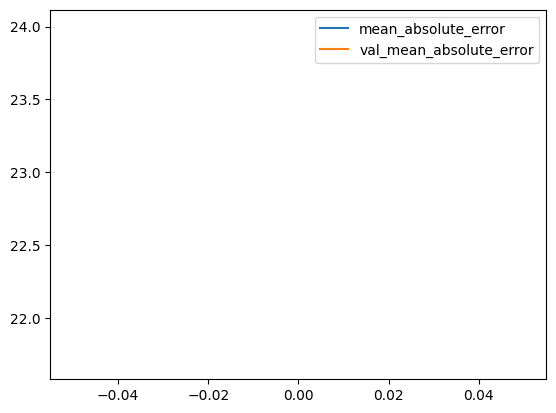

52/52 [==============================] - 87s 855ms/step - loss: 1694.6866 - mean_absolute_error: 21.6932 - val_loss: 1768.7545 - val_mean_absolute_error: 24.0002
Epoch 2/20
52/52 [==============================] - ETA: 0s - loss: 1304.2858 - mean_absolute_error: 19.4397
Epoch 2: val_mean_absolute_error did not improve from 24.00021


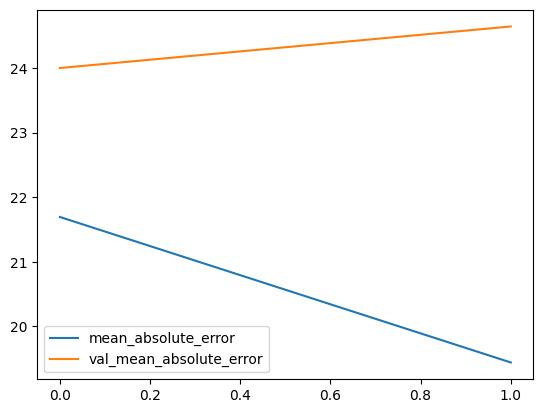

52/52 [==============================] - 28s 545ms/step - loss: 1304.2858 - mean_absolute_error: 19.4397 - val_loss: 2171.6440 - val_mean_absolute_error: 24.6436
Epoch 3/20
52/52 [==============================] - ETA: 0s - loss: 1066.5496 - mean_absolute_error: 18.0258
Epoch 3: val_mean_absolute_error improved from 24.00021 to 19.99816, saving model to temp-from-sc.keras


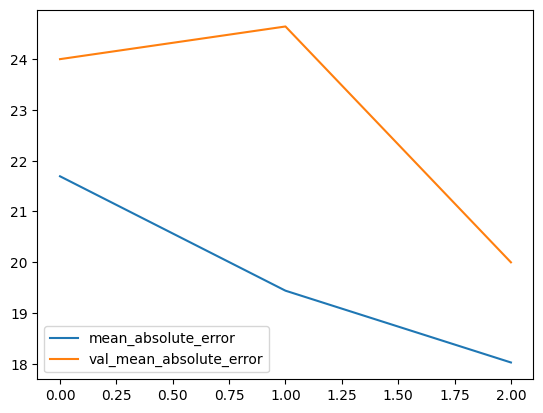

52/52 [==============================] - 31s 603ms/step - loss: 1066.5496 - mean_absolute_error: 18.0258 - val_loss: 1290.0052 - val_mean_absolute_error: 19.9982
Epoch 4/20
52/52 [==============================] - ETA: 0s - loss: 906.4679 - mean_absolute_error: 16.9158
Epoch 4: val_mean_absolute_error did not improve from 19.99816


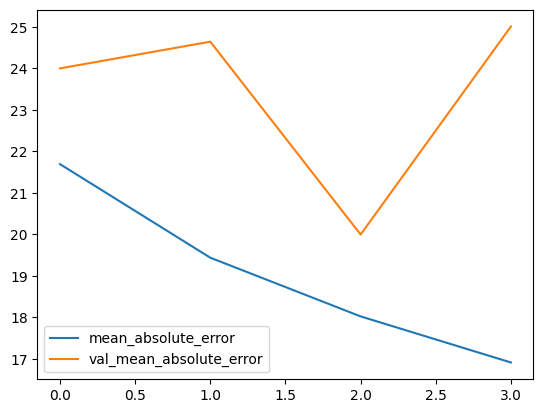

52/52 [==============================] - 27s 525ms/step - loss: 906.4679 - mean_absolute_error: 16.9158 - val_loss: 2247.6648 - val_mean_absolute_error: 25.0097
Epoch 5/20
52/52 [==============================] - ETA: 0s - loss: 778.3040 - mean_absolute_error: 15.7827
Epoch 5: val_mean_absolute_error did not improve from 19.99816


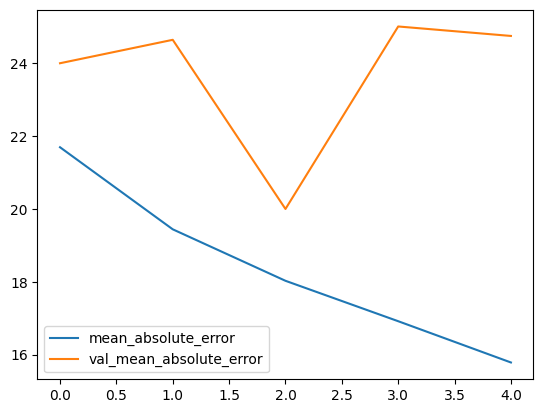

52/52 [==============================] - 27s 526ms/step - loss: 778.3040 - mean_absolute_error: 15.7827 - val_loss: 2189.2734 - val_mean_absolute_error: 24.7497
Epoch 6/20
52/52 [==============================] - ETA: 0s - loss: 704.3356 - mean_absolute_error: 15.3260
Epoch 6: val_mean_absolute_error did not improve from 19.99816


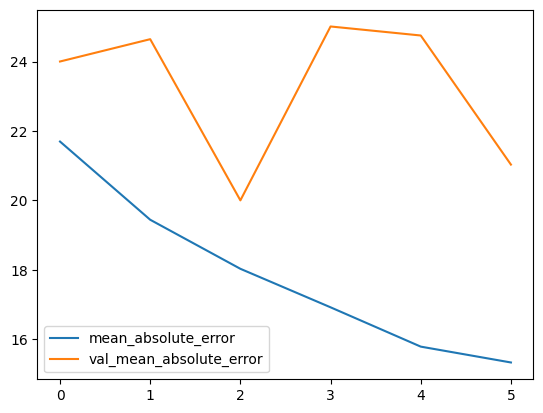

52/52 [==============================] - 27s 527ms/step - loss: 704.3356 - mean_absolute_error: 15.3260 - val_loss: 1452.0077 - val_mean_absolute_error: 21.0292
Epoch 7/20
52/52 [==============================] - ETA: 0s - loss: 626.0927 - mean_absolute_error: 14.6762
Epoch 7: val_mean_absolute_error did not improve from 19.99816


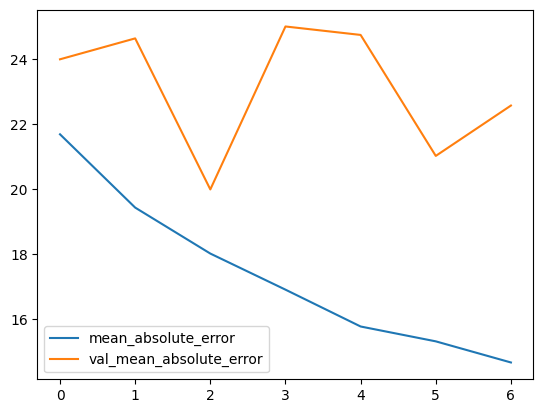

52/52 [==============================] - 28s 528ms/step - loss: 626.0927 - mean_absolute_error: 14.6762 - val_loss: 1153.4153 - val_mean_absolute_error: 22.5781
Epoch 8/20
52/52 [==============================] - ETA: 0s - loss: 592.4080 - mean_absolute_error: 14.6492
Epoch 8: val_mean_absolute_error improved from 19.99816 to 16.65798, saving model to temp-from-sc.keras


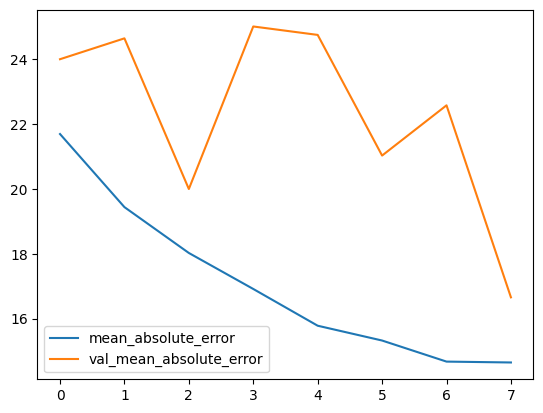

52/52 [==============================] - 31s 602ms/step - loss: 592.4080 - mean_absolute_error: 14.6492 - val_loss: 723.1884 - val_mean_absolute_error: 16.6580
Epoch 9/20
52/52 [==============================] - ETA: 0s - loss: 541.4146 - mean_absolute_error: 14.1013
Epoch 9: val_mean_absolute_error improved from 16.65798 to 15.28693, saving model to temp-from-sc.keras


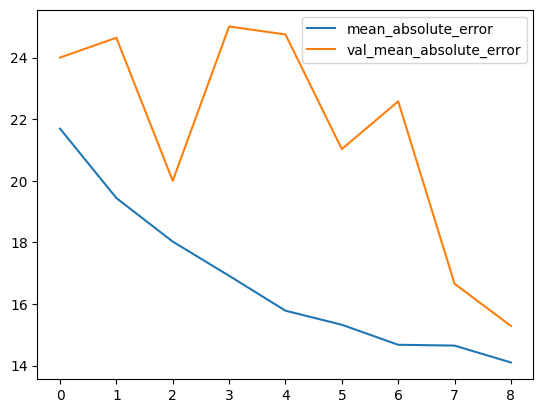

52/52 [==============================] - 31s 596ms/step - loss: 541.4146 - mean_absolute_error: 14.1013 - val_loss: 681.0157 - val_mean_absolute_error: 15.2869
Epoch 10/20
52/52 [==============================] - ETA: 0s - loss: 526.4587 - mean_absolute_error: 14.1462
Epoch 10: val_mean_absolute_error did not improve from 15.28693


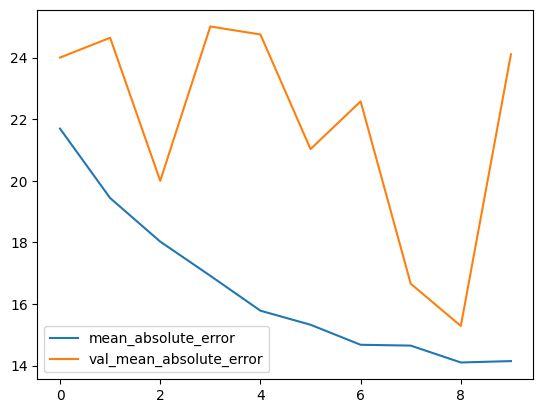

52/52 [==============================] - 28s 527ms/step - loss: 526.4587 - mean_absolute_error: 14.1462 - val_loss: 2007.1517 - val_mean_absolute_error: 24.1072
Epoch 11/20
52/52 [==============================] - ETA: 0s - loss: 514.2732 - mean_absolute_error: 14.0678
Epoch 11: val_mean_absolute_error did not improve from 15.28693


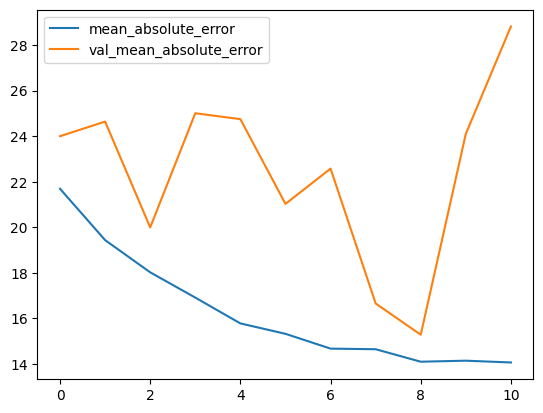

52/52 [==============================] - 27s 534ms/step - loss: 514.2732 - mean_absolute_error: 14.0678 - val_loss: 1814.4368 - val_mean_absolute_error: 28.8182
Epoch 12/20
52/52 [==============================] - ETA: 0s - loss: 485.5154 - mean_absolute_error: 13.8674
Epoch 12: val_mean_absolute_error improved from 15.28693 to 14.48012, saving model to temp-from-sc.keras


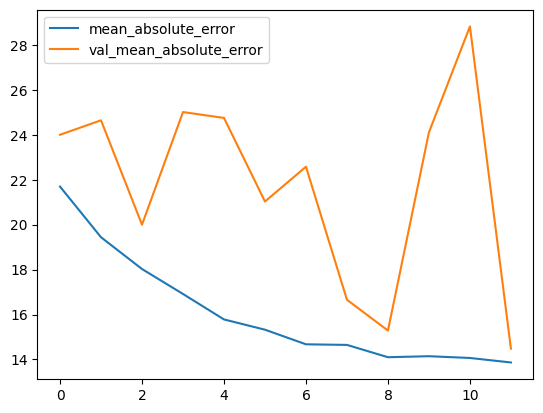

52/52 [==============================] - 31s 591ms/step - loss: 485.5154 - mean_absolute_error: 13.8674 - val_loss: 533.6773 - val_mean_absolute_error: 14.4801
Epoch 13/20
52/52 [==============================] - ETA: 0s - loss: 452.2565 - mean_absolute_error: 13.4184
Epoch 13: val_mean_absolute_error improved from 14.48012 to 14.38667, saving model to temp-from-sc.keras


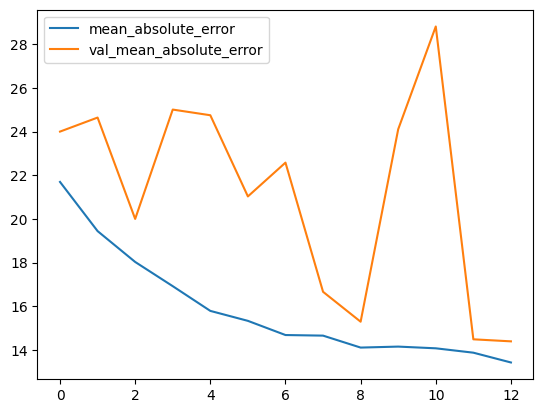

52/52 [==============================] - 31s 595ms/step - loss: 452.2565 - mean_absolute_error: 13.4184 - val_loss: 505.3237 - val_mean_absolute_error: 14.3867
Epoch 14/20
52/52 [==============================] - ETA: 0s - loss: 440.8929 - mean_absolute_error: 13.4204
Epoch 14: val_mean_absolute_error did not improve from 14.38667


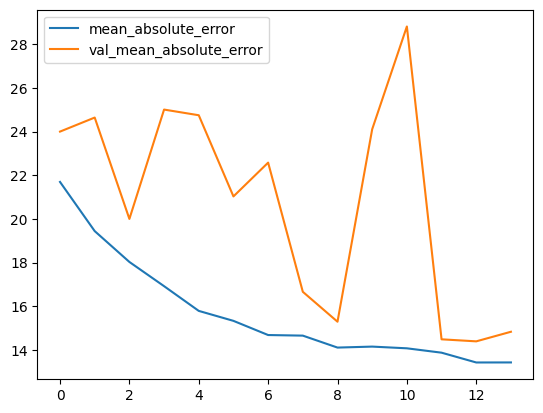

52/52 [==============================] - 28s 529ms/step - loss: 440.8929 - mean_absolute_error: 13.4204 - val_loss: 627.9141 - val_mean_absolute_error: 14.8265
Epoch 15/20
52/52 [==============================] - ETA: 0s - loss: 449.9117 - mean_absolute_error: 13.6779
Epoch 15: val_mean_absolute_error did not improve from 14.38667


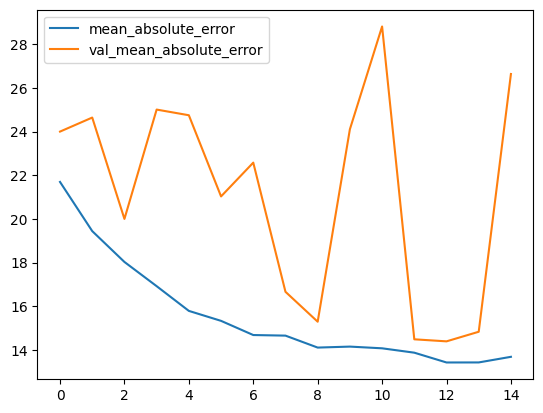

52/52 [==============================] - 28s 528ms/step - loss: 449.9117 - mean_absolute_error: 13.6779 - val_loss: 1561.5061 - val_mean_absolute_error: 26.6402
Epoch 16/20
52/52 [==============================] - ETA: 0s - loss: 471.3818 - mean_absolute_error: 13.9079
Epoch 16: val_mean_absolute_error did not improve from 14.38667


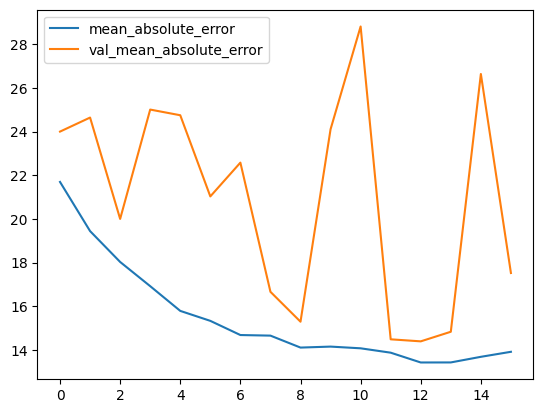

52/52 [==============================] - 28s 528ms/step - loss: 471.3818 - mean_absolute_error: 13.9079 - val_loss: 697.3740 - val_mean_absolute_error: 17.5187
Epoch 17/20
52/52 [==============================] - ETA: 0s - loss: 434.0524 - mean_absolute_error: 13.3871
Epoch 17: val_mean_absolute_error improved from 14.38667 to 14.36949, saving model to temp-from-sc.keras


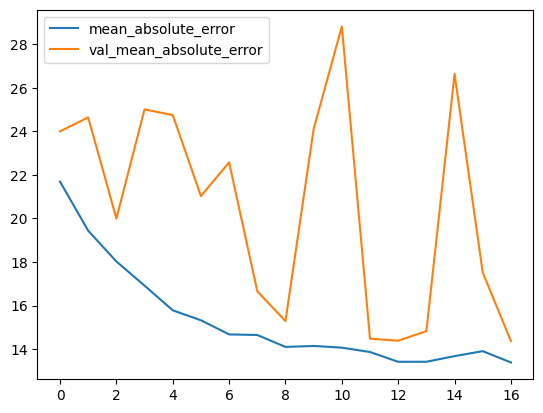

52/52 [==============================] - 31s 592ms/step - loss: 434.0524 - mean_absolute_error: 13.3871 - val_loss: 583.6633 - val_mean_absolute_error: 14.3695
Epoch 18/20
52/52 [==============================] - ETA: 0s - loss: 412.1682 - mean_absolute_error: 13.1503
Epoch 18: val_mean_absolute_error did not improve from 14.36949


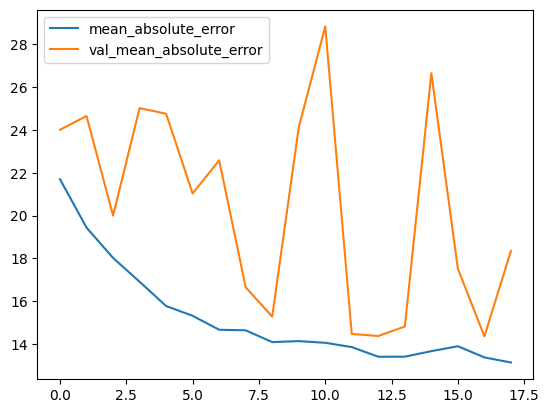

52/52 [==============================] - 28s 528ms/step - loss: 412.1682 - mean_absolute_error: 13.1503 - val_loss: 970.9111 - val_mean_absolute_error: 18.3505
Epoch 19/20
52/52 [==============================] - ETA: 0s - loss: 416.7556 - mean_absolute_error: 13.2074
Epoch 19: val_mean_absolute_error did not improve from 14.36949


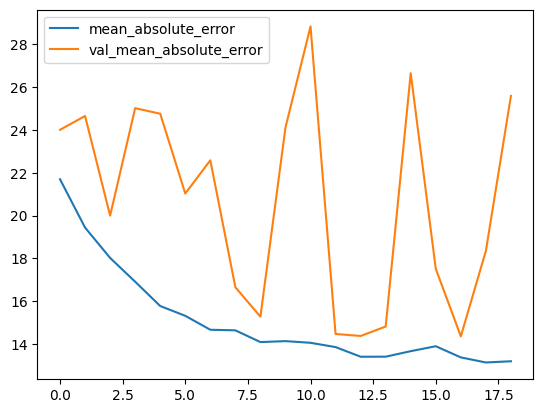

52/52 [==============================] - 28s 528ms/step - loss: 416.7556 - mean_absolute_error: 13.2074 - val_loss: 2370.3645 - val_mean_absolute_error: 25.5800
Epoch 20/20
52/52 [==============================] - ETA: 0s - loss: 420.4717 - mean_absolute_error: 13.1059
Epoch 20: val_mean_absolute_error did not improve from 14.36949


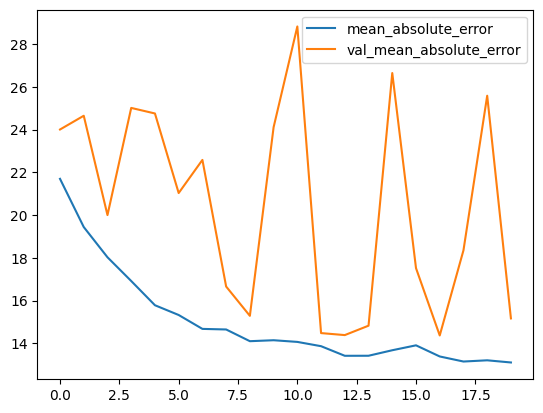

52/52 [==============================] - 28s 528ms/step - loss: 420.4717 - mean_absolute_error: 13.1059 - val_loss: 637.7645 - val_mean_absolute_error: 15.1661


In [10]:
# Train the Model
train_generator.reset()
model.fit(
    x=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, plot_losses],
)

In [11]:
from keras.models import load_model

# Test Model
model = load_model("temp-from-sc.keras")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 500, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 298, 498, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 296, 496, 64)      36928     
                                                                 
 batch_normalization (Batch  (None, 296, 496, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 248, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 146, 246, 128)     73856 

In [12]:
validation_generator.reset()
predict = model.predict(
    x=validation_generator,
    steps=len(validation_generator),
    workers=1,
    use_multiprocessing=False,
)

val_set = validation_set.copy()
val_set["meat"] = predict[:, 0]
val_set["veggie"] = predict[:, 1]
val_set["noodle"] = predict[:, 2]
val_set.compare(validation_set)

12/12 [==============================] - 2s 169ms/step


meat           veggie            noodle      
           self other       self other        self other
1815  16.113897     7  19.994780     0  127.179375    80
104   16.982710    41  20.641405    32  130.062836   186
1411   3.878749     0  12.942483    50    1.758209     0
1684   3.821775     0  12.902088    33    1.095388     0
413    5.733115     3  14.093884     5   44.637962    59
...         ...   ...        ...   ...         ...   ...
1188   4.916031    14  13.881803     3   17.899467    11
1697   4.905344     0  14.009543    57   22.142448     0
1173   4.319273    14  13.288131     0    7.311542     0
1429   4.032948     0  13.059833    55    3.595186    20
1760   3.911607     3  12.966634     2    2.135293     0

[372 rows x 6 columns]

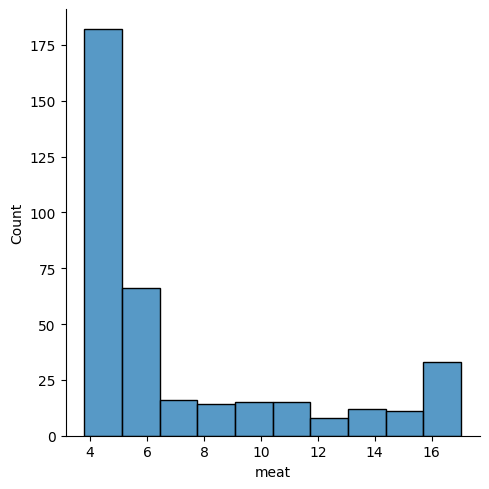

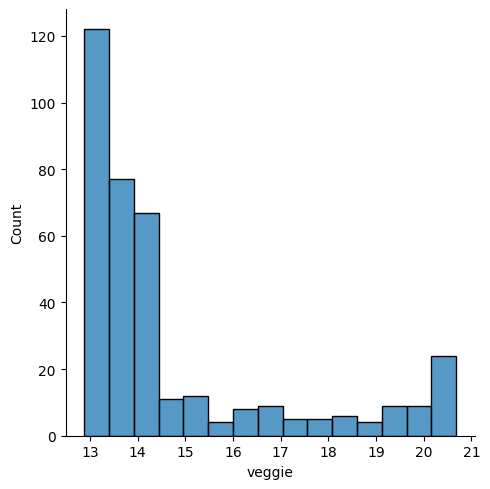

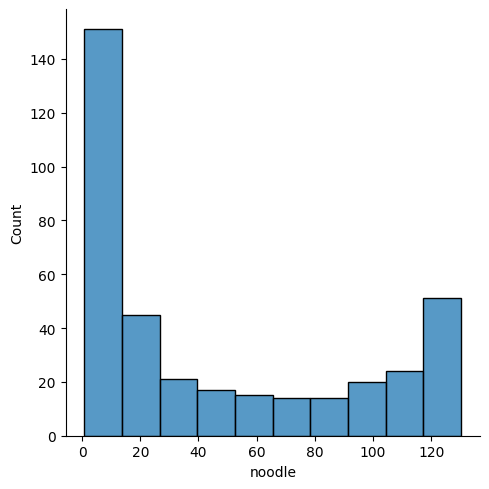

In [13]:
import seaborn as sns

sns.displot(val_set, x="meat")
sns.displot(val_set, x="veggie")
sns.displot(val_set, x="noodle")

In [14]:
(val_set["meat"] - validation_set["meat"]).abs().mean()

6.578802283733122

In [15]:
(val_set["veggie"] - validation_set["veggie"]).abs().mean()

14.168031384868007

In [16]:
(val_set["noodle"] - validation_set["noodle"]).abs().mean()

22.36162766301504